*This Orientation-Course is on PyPSA and PyPSA-EUR. Read through it for a general idea how PyPSA works and what ther difference is to PyPSA-EUR.*  
**Author: Jonas Groß, last update: 29.01.26**

# What is PyPSA?

PyPSA stands for Python for Power System Analysis.  
It is an open-source Python framework for optimising modern power systems with conventional generators, renewable energy, storage, and multi-sector coupling - designed for researchers and planners.
It is focused on optimising investment and operational costs for the whole system.  

## Framework Components of PyPSA:

- **Powerplantmatching** - A toolset for cleaning, standardizing and combining multiple power plant databases
- **Technology Data** - Compile assumptions on energy system technologies for various years
- **Atlite** - A Lightweight Python Package for Calculating Renewable Power Potentials and Time Series
- **linopy** - Linear optimization interface for N-D labeled variables
- **Map Your Grid** - Community-driven initiative mapping the world's electrical grids to accelerate the energy transition worldwide (= Open Street Map Data on Electrical Grids)

## Different PyPSA Models
- PyPSA-Earth
- PyPSA-EUR
- PyPSA-DE
- PyPSA-USA

[https://pypsa.org/, https://ariadneprojekt.de/modell-dokumentation-pypsa/ (accessed: 27.01.2026)]

# Short Presentation for PyPSA

Quickstart 3 - **Investments & Storage**

A data centre in Seville, Spain, has a constant demand of 100 MW. The operator considers investing in on-site solar PV and battery storage to reduce reliance on grid electricity, which is priced at 120 €/MWh.  
Find the least-cost investment in solar PV and battery storage to cover the load. What is the average cost per unit of electricity consumed? How much electricity is consumed from the grid and when? How is the battery operated?

[https://docs.pypsa.org/latest/examples/example-3/ (accessed: 27.01.2026)]

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pypsa
from pypsa.common import annuity

n = pypsa.Network()

n.add("Bus", "seville")
n.add("Load", "demand", bus="seville", p_set=100)
n.add("Generator", "grid", bus="seville", p_nom=100, marginal_cost=120, carrier="grid")

# read in the solar data
p_max_pu = pd.read_csv(
    "https://model.energy/data/time-series-f17c3736a2719ce7da58484180d89e2d.csv",
    index_col=0,
    parse_dates=True,
)["solar"]

# optimize for time steps
n.set_snapshots(p_max_pu.index)
len(n.snapshots)

# add a solar generator with the time series data
n.add(
    "Generator",
    "solar",
    bus="seville",
    p_max_pu=p_max_pu,
    capital_cost=annuity(0.05, 25) * 400_000,
    p_nom_extendable=True,
    carrier="solar",
)

# add battery storage with component costs
cc_inverter = annuity(0.05, 25) * 170_000
cc_storage = annuity(0.05, 25) * 150_000

n.add(
    "StorageUnit",
    "battery",
    bus="seville",
    capital_cost=cc_inverter + 4 * cc_storage,
    p_nom_extendable=True,
    carrier="battery",
    efficiency_store=np.sqrt(0.9),
    efficiency_dispatch=np.sqrt(0.9),
    max_hours=4,
)

# solve model
n.optimize()


Index(['seville'], dtype='object', name='name')
Index(['grid', 'solar'], dtype='object', name='name')
Index(['battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 167.39it/s]
INFO:linopy.io: Writing time: 0.44s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43802 primals, 105122 duals
Objective: 4.83e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [63]:
# optimal capacities
print(n.statistics.optimal_capacity())

component    carrier
Generator    grid       100.00000
             solar      659.77841
StorageUnit  battery    351.37184
dtype: float64


In [64]:
# opex and capex
totex = {"opex": n.statistics.opex(), "capex": n.statistics.capex()}
print(pd.concat(totex, axis=1).div(1e6).round(2))  # M€/a

                      opex  capex
component   carrier              
Generator   grid     10.36    NaN
            solar      NaN  18.73
StorageUnit battery    NaN  19.20


In [65]:
# energy balance
print(n.statistics.energy_balance().div(1e3))  # GWh

component    carrier  bus_carrier
Generator    grid     AC              86.354010
             solar    AC             836.363402
Load         -        AC            -876.000000
StorageUnit  battery  AC             -46.717412
dtype: float64


In [66]:
n.add(
    "Carrier",
    ["grid", "solar", "battery", "AC"],
    color=["blue", "yellow", "green", "k"],
)
n.statistics.energy_balance.iplot() # PyPSA includes plotly integration for interactive plots

In [ ]:
# exporting results to files
n.export_to_excel("../data/PyPSA-Orientation Course/data-centre-investment.xlsx")
n.export_to_netcdf("../data/PyPSA-Orientation Course/data-centre-investment.nc")

o = pypsa.Network("data-centre-investment.nc")

# creating these files is a big part of PyPSA and especially for PyPSA-EUR
# netcdf is not so easy to read but consists of a bunch of binary files, which are easily imported back into PyPSA

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'data-centre-investment.xlsx contains: storage_units, carriers, sub_networks, loads, buses, generators
INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'data-centre-investment.nc contains: storage_units, carriers, sub_networks, loads, buses, generators
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, loads, storage_units, sub_networks


# PyPSA-EUR
PyPSA-Eur is an open model dataset of the European energy system at the transmission network level that covers the full ENTSO-E area. It covers demand and supply for all energy sectors.
## Electricity System
The electricity system representation contains alternating current lines at and above 220 kV voltage level and all high voltage direct current lines, substations, an open database of conventional power plants, time series for electrical demand and variable renewable generator availability, geographic potentials for the expansion of wind and solar power.  
The model is suitable both for operational studies and generation and transmission expansion planning studies. The continental scope and highly resolved spatial scale enables a proper description of the long-range smoothing effects for renewable power generation and their varying resource availability.
## Sector-Coupled Energy System
A sector-coupled extension (previously known as PyPSA-Eur-Sec, which is now deprecated) adds demand and supply for the following sectors: transport, space and water heating, biomass, energy consumption in the agriculture, industry and industrial feedstocks, carbon management, carbon capture and usage/sequestration.  
(This is not explained further in this orientation course)

[https://pypsa-eur.readthedocs.io/en/latest/ (accessed: 27.01.2026)]

## The Workflow of PyPSA-EUR
The workflow of PyPSA-EUR is quite different to what is done in PyPSA or shown in the above tutorial. This is because it uses more complex data sources to build models. A lot of it is easily configurable.

The generation of the model is controlled by the **open workflow management system Snakemake**. In a nutshell, the Snakefile declares for each script in the scripts directory a rule which describes which files the scripts consume and produce (their corresponding input and output files). The snakemake tool then runs the scripts in the correct order according to the rules’ input and output dependencies. Moreover, snakemake will track what parts of the workflow have to be regenerated when files or scripts were modified.

**Version Presented on 28.01.25**
So snakemake works a lot with file names (and paths) and rules!  
These filenames follow a certain naming convention, defined by wildcards. For Example:  
"snakemake -call results/networks/base_s_128_elec_.nc"  
would create a netCDF-file for a network that has 128 clusters and only the electricity grid. It is excuted in a terminal (perfect for hpc solving).

It has been quite a challange to figure out these file names! Correct naming is important, so the Snakemake rules can be used: 

networks/base_s_{clusters}_{opts}_{sector_opts}_{planning_horizons}.nc"


Parameters set in the filename according to the documentation (which is not great in regards to the wildcard feature):
1. {cutout}
2. {technology}
3. {clusters}
4. {opts}
5. {sector_opts}
6. {planning_horizons}

[https://pypsa-eur.readthedocs.io/en/latest/wildcards.html (accessed: 27.01.2026)]

*Added on 29.01.26:*  
**Alternativly to file-names: Call Rules** you can also use rules to produce results. Then snakemake will determine which files need to be created.  
Example:  
"snakemake -call solve_elec_networks --configfile ../config/s2h-minimal-V3.yaml --latency-wait 300 --cores all"

### File Name via wildcards (added 13.02.26)
the file name (results/networks/elec_s_6_ec_lcopt_Co2L-24H) consist of: 
- "elec": could also be base if all sectors should be accounted for
- "s": means simplified, so not all clusters, but simplified to a certain number
- "ec": e for electricity and c for constraint **NOT SURE**
- "lcopt": lc for line capacity and opt for optimal
- "Co2L": CO2-Limit
- "24H": 24 Hours Blocks instead of 1h


## Configuration Files
Any PyPSA-EUR configuration can be set in a -yaml file. This will overwrite parts of the config.default.yaml.  
The configuration is a rule set for the workflow and defines the scopes of the optimization.  
There is quite good documentation on Configuration Files

[https://pypsa-eur.readthedocs.io/en/latest/configuration.html (accessed: 27.01.2026)]

## data sources
In general PyPSA-EUR is built on top of PyPSA. The main advantage is the included data collection and management.  
Most of the dependencies are shipped with the repository. But for some of the data sources you need a license to access the API.  
(Up to now we only found the build_cutout rule to need an API [https://pypsa-eur.readthedocs.io/en/latest/preparation.html#module-build_cutout (accessed: 27.01.2026)])

The Data Sources are well documented and show some limitations.  
[https://pypsa-eur.readthedocs.io/en/latest/data_sources.html (accessed: 27.01.2026)]

## limitations

A big limitation for the Store2Hydro Project is that the database for hydro-electric power plants does not include plant-specific energy storage information, so that blanket values based on country storage totals have been used. Inflow time series are based on country-wide approximations, ignoring local topography and basin drainage. 

There is also other limitations:
[https://pypsa-eur.readthedocs.io/en/latest/limitations.html (accessed: 27.01.2026)]


## pre build networks
There are prebuilt networks on: https://zenodo.org/records/3601882  

INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, lines, links, loads, storage_units


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x212a1a265d0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x212a1a26710>,
  'Line': <matplotlib.collections.LineCollection at 0x212a1a26850>},
 'flows': {}}

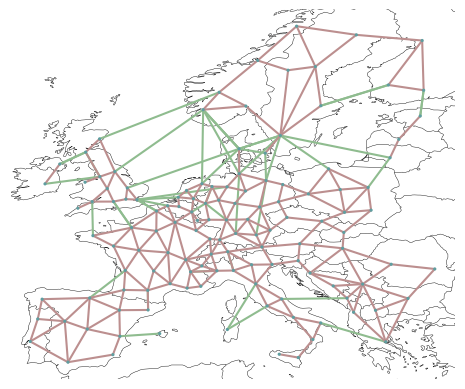

In [89]:
n2 = pypsa.Network("../data/networks/elec_s_128_ec.nc")
n2.plot()

INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, lines, links, transformers


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x2129fd02ad0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x2129fd02c10>,
  'Line': <matplotlib.collections.LineCollection at 0x2129fd02d50>,
  'Transformer': <matplotlib.collections.LineCollection at 0x2129fd02e90>},
 'flows': {}}

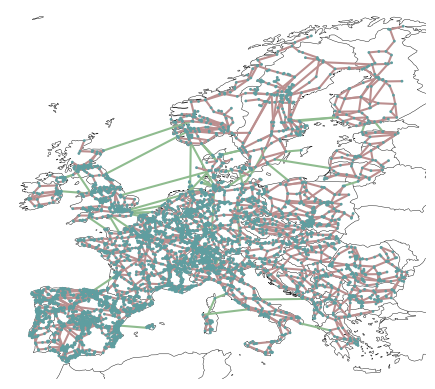

In [90]:
n3 = pypsa.Network("../data/networks/base.nc")
n3.plot()

In [ ]:
print(n2.storage_units.info()) 
# in pypsa-eur hydro reservoirs are not modelled as generators but as storage units

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, AT0 0 PHS to SK0 0 H2
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   bus                                 397 non-null    object 
 1   control                             397 non-null    object 
 2   type                                397 non-null    object 
 3   p_nom                               397 non-null    float64
 4   p_nom_mod                           397 non-null    float64
 5   p_nom_extendable                    397 non-null    bool   
 6   p_nom_min                           397 non-null    float64
 7   p_nom_max                           397 non-null    float64
 8   p_nom_set                           0 non-null      float64
 9   p_min_pu                            397 non-null    float64
 10  p_max_pu                            397 non-null    float64
 11  p_set                               0

In [92]:
print(n2.storage_units.groupby("carrier")["p_nom"].sum().round(1))

carrier
H2             0.0
PHS        54593.6
battery        0.0
hydro      99562.2
Name: p_nom, dtype: float64


In [93]:
print(n2.generators.groupby("carrier")["p_nom"].sum().round(1))

carrier
CCGT          155977.4
OCGT           39668.6
biomass         9901.8
coal          119627.3
geothermal       828.8
lignite        50157.8
nuclear       130427.6
offwind-ac         0.0
offwind-dc         0.0
oil            32026.2
onwind             0.0
ror            34503.9
solar              0.0
Name: p_nom, dtype: float64


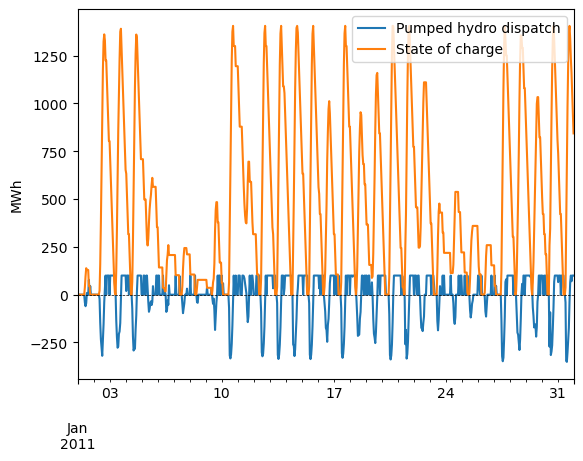

In [94]:
fig, ax = plt.subplots()

p_storage_week = n.storage_units_t.p.loc["2011-01-01":"2011-01-31"].sum(axis=1)
state_of_charge_week = n.storage_units_t.state_of_charge.loc["2011-01-01":"2011-01-31"].sum(axis=1)

p_storage_week.plot(label="Pumped hydro dispatch", ax=ax)
state_of_charge_week.plot(label="State of charge", ax=ax)

ax.axhline(0, color="k", lw=0.5, ls="--")
ax.legend()
ax.set_ylabel("MWh")
ax.set_xlabel("")

plt.show()

## testing on the tutorial
https://pypsa-eur.readthedocs.io/en/latest/tutorial.html

(after installation open the terminal and execute the steps)
1. activate pypsa-eur
2. cd pypsa-eur
3. snakemake -call ../pypsa-eur/results/test-elec/networks/base_s_6_elec_.nc --configfile ../pypsa-eur/config/test/config.electricity.yaml --cores all --latency-wait 300

In [ ]:
n = pypsa.Network("../pypsa-eur/results/test-elec/networks/base_s_6_elec_.nc")
n.plot()